
# How to Pull Data on NFT's, Their Sales, and Visualize Them
# NFT Data Science pt. 1 - Intro to OpenSea API

##### *By Alex Duffy elaborating on Adil Moujahid's framework* 

# In my opinion, cryptocurrency is digital native currency, or currency made for and on a digital medium / the internet). In a similar vein, non-fungible tokens (NFT’s) are digital native THINGS that you can buy with said currency and own. THINGS that you hold in your secure wallet, THINGS can be read and interacted with by any website that you give permission to, THINGS that can often be bought sold and traded.

OpenSea is the first and largest NFT marketplace created in June 2018. During that month 26 NFT’s were sold for just under \$$ 600 combined. Last month as of writing this (August 2021) 1.6 million NFT’s sold for \$ 3.4 billion USD; more than all previous months combined. That may have been a fluke and NFT’s may be a fad, or it could be a great time to learn more, look at popular collections, and analyze their trends.

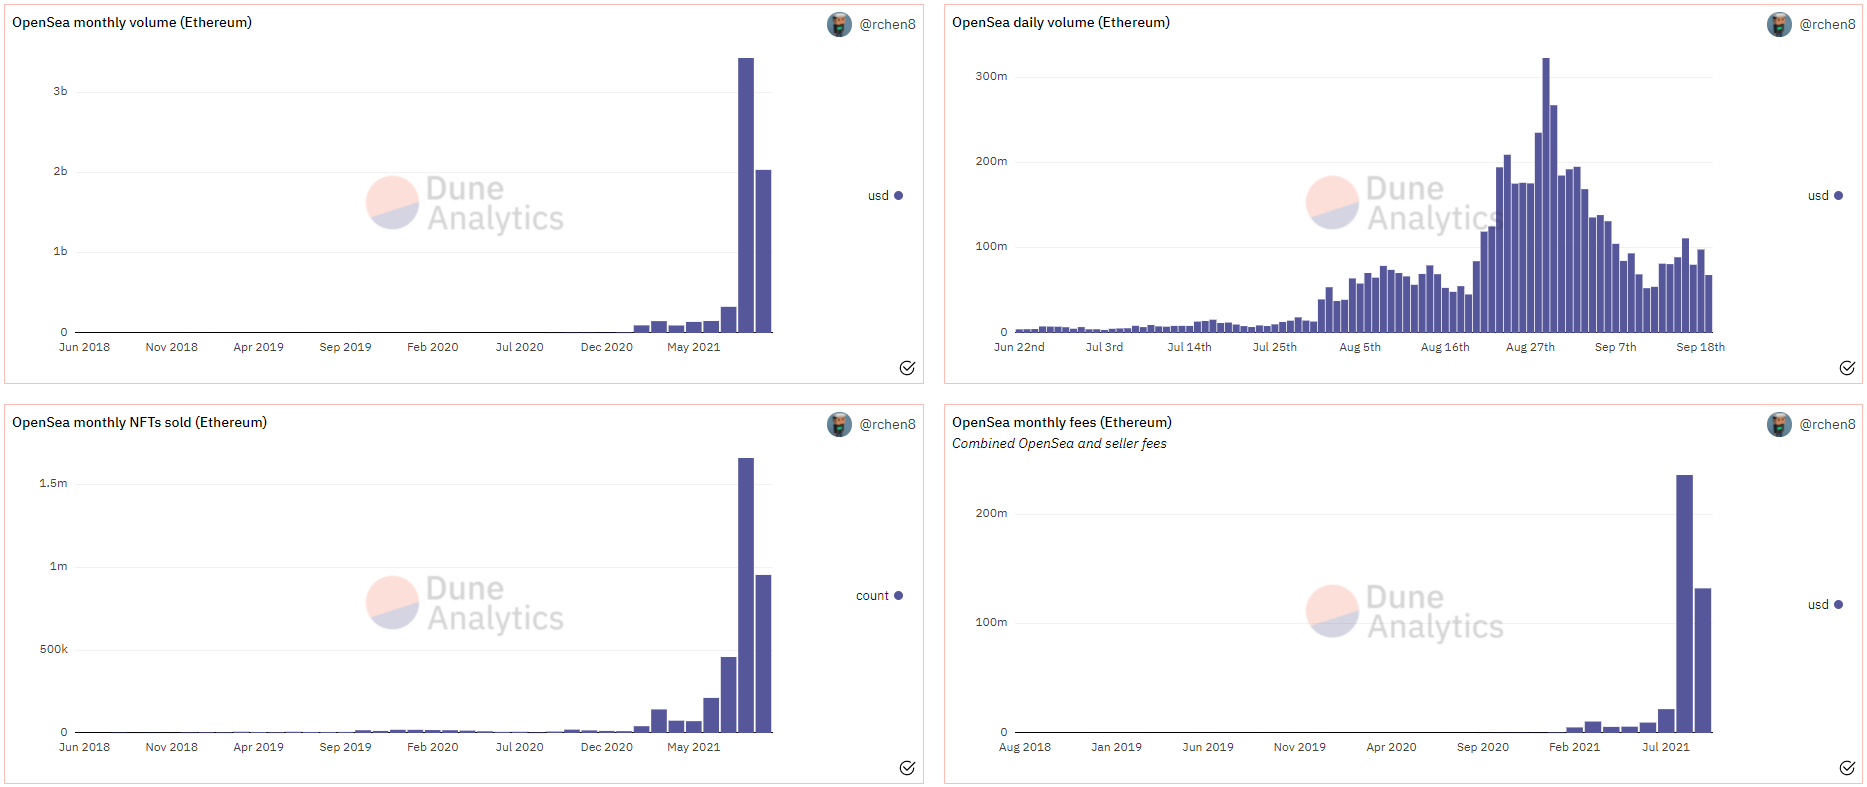
*Analytics dashboard on OpenSea made by user rchen8* - https://dune.xyz/rchen8/opensea 

As an example I will be investigating the NFT collection Animetas, one that I am particularly interested in along with the Savage Droids collection which will be explored in part 2. 

As you follow along, you can change the collection this notebook pulls data for. All you have to do is replace 'asset_contract_address' with the smart contract address of your choice. This address can be found through OpenSea

*Note: You will have to change the start and and dates as well for data pulling. The initial query could take some time and require additional sleep time between loops to not throttle but once pulled and saved you can set dates to only query new data. That way you would only need to load saved data greatly reducing wait time for getting the most updated info.* 

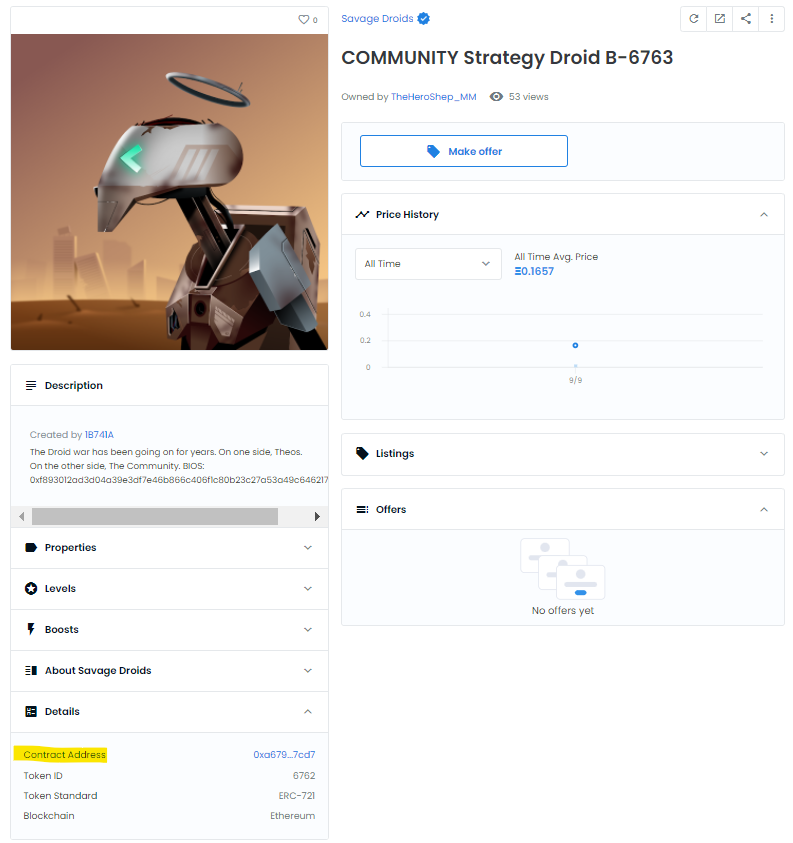


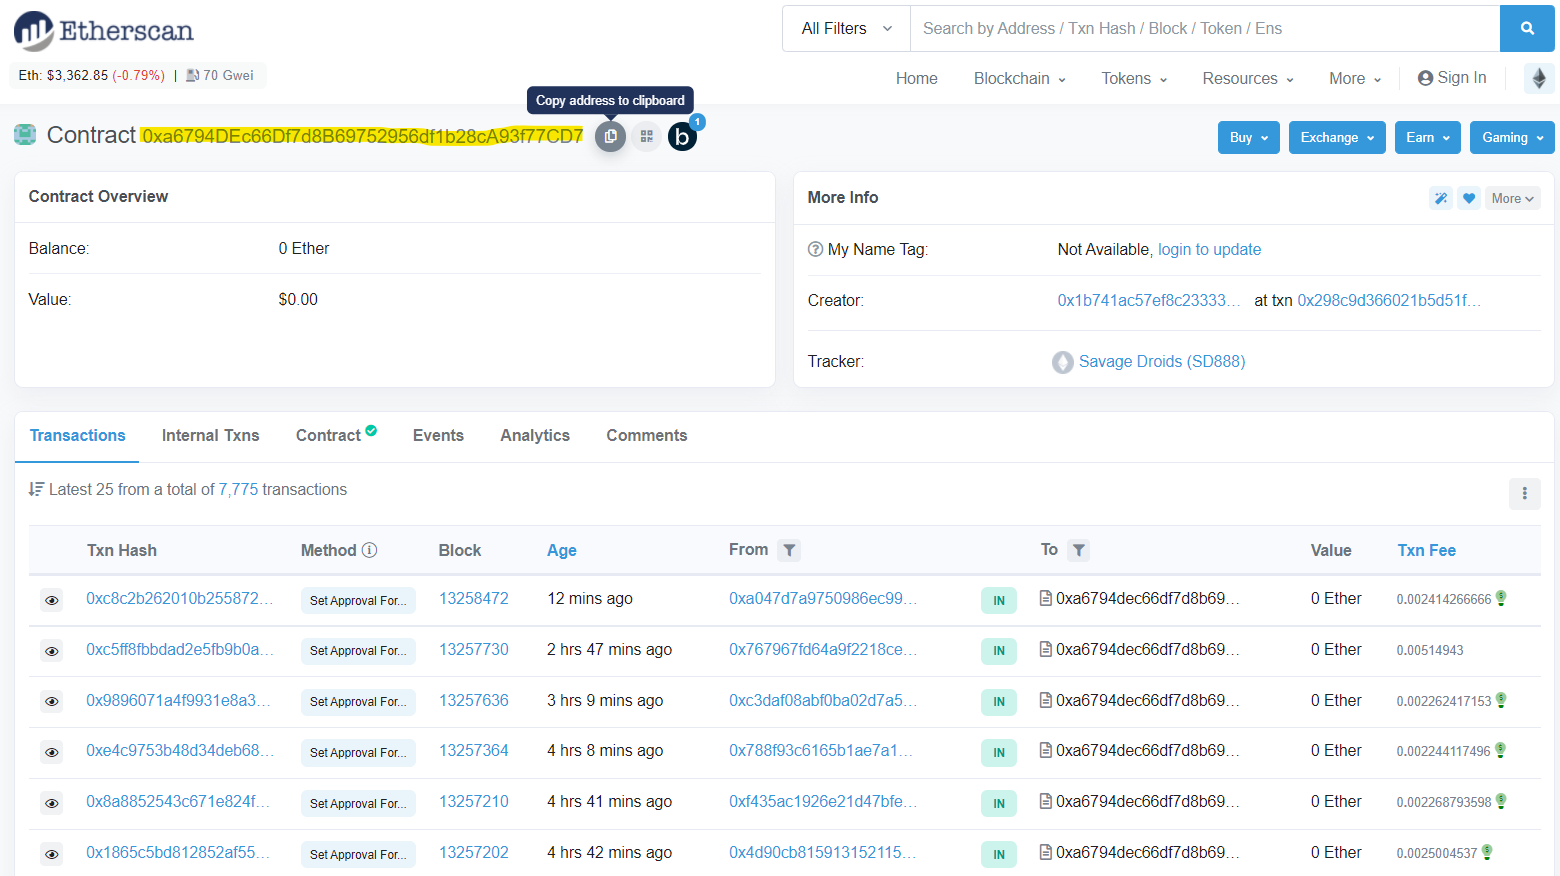

### Notebook Functionalities:
* [Pull and Save NFT Data](#get-nft)
* [Pull and Save NFT Sales](#get-sales)
* [Pull and Save NFT Listings](#get-listings)
* [Load and Pre-Process Data](#load)
* [Basic Analysis](#analysis)
* [Macro Visualization](#visual)

In [36]:
asset_contract_address = "0x18Df6C571F6fE9283B87f910E41dc5c8b77b7da5"

In [2]:
%matplotlib inline

In [3]:
from helpers import parse_events_data, parse_assets_data, parse_sale_data, parse_listing_data

import requests
import pandas as pd
from pandas_profiling import ProfileReport
import pickle

from statistics import *
import numpy as np
from scipy.stats import combine_pvalues

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import time
from datetime import date, timedelta, datetime

import os
import glob

### Simple demo of the OpenSea API
#### Shows all information possible from Assets and Events without pre-processing

Here we demonstrate how to requests information from the OpenSea API and what data comes in that response for Assets and Events.

- Assets are the NFT's themselves, e.g. Droid B-6763 pictured above
- Events are transactions of NFT's, e.g. sales, listings, bids entered, bids withdrawn, etc. 

#### Assets 

In [4]:
url = "https://api.opensea.io/api/v1/assets"

querystring = {"token_ids":list(range(0, 30)),
               "asset_contract_address":asset_contract_address,
               "order_direction":"desc",
               "offset":"0",
               "limit":"30"}
response = requests.request("GET", url, params=querystring)


# Getting asset data
assets = response.json()['assets']
if assets == []:
    print('empty')

In [5]:
sample_asset = pd.DataFrame.from_dict(assets[0], orient='index')
sample_asset

,0
id,33619906
token_id,26
num_sales,0
background_color,None
image_url,https://lh3.googleusercontent.com/SEpYcwGMcQo6...
image_preview_url,https://lh3.googleusercontent.com/SEpYcwGMcQo6...
image_thumbnail_url,https://lh3.googleusercontent.com/SEpYcwGMcQo6...
image_original_url,https://gateway.pinata.cloud/ipfs/QmbfuMdX9qiM...
animation_url,None
animation_original_url,None


#### Events

In [6]:
url = "https://api.opensea.io/api/v1/events"

querystring = {"asset_contract_address":asset_contract_address,
               "event_type":"successful",
               "only_opensea":"true",
               "offset":0,
               "limit":"300"}
headers = {"Accept": "application/json"}

response = requests.request("GET", url, headers=headers, params=querystring)

# Getting event data
events = response.json()['asset_events']
if events == []:
    print('empty')

In [7]:
sample_event = pd.DataFrame.from_dict(assets[0], orient='index')
sample_event

,0
id,33619906
token_id,26
num_sales,0
background_color,None
image_url,https://lh3.googleusercontent.com/SEpYcwGMcQo6...
image_preview_url,https://lh3.googleusercontent.com/SEpYcwGMcQo6...
image_thumbnail_url,https://lh3.googleusercontent.com/SEpYcwGMcQo6...
image_original_url,https://gateway.pinata.cloud/ipfs/QmbfuMdX9qiM...
animation_url,None
animation_original_url,None


## Pull and Save NFT Data <a class="anchor" id="get-nft"></a>

#### Getting Assets Data

The code below collects assets data about all the assets. The API has a limit of 50 items per call and a max offset of 10,000. In order to circumvent this we increment token id instead of offest which leaves room for bugs if the tokens are not numbered in ascending order. We also need to be aware if the first token has the ID 0 or the ID of 1. 

We use the parsing provided in Adil Moujahid's framework to focus on these fields for each asset: 

##### Asset Data Parsed:
- 'asset_id'
- 'creator_username'
- 'creator_address'
- 'owner_username'
- 'owner_address'
- 'traits'
- 'num_sales'

We also need to store this data somehow to be able to read from it locally instead of having to do the lengthy request every time we want to update our visuals. 

One option is using pickle to save dataframes and lists. While convenient, it is not memory efficient. One option which we explore in part two is saving arrays as .npz files. Another alternative altogether suited for a more production ready environment would be feeding that data into a postgres SQL database. 

In [8]:
def download_asset_info(save_location):
    if not os.path.isdir(save_location):
        os.makedirs(save_location)
    url = "https://api.opensea.io/api/v1/assets"
    listoassets = []

    for i in range(0, 3000):
        querystring = {"token_ids":list(range((i*30), (i*30)+30)),
                       "asset_contract_address":asset_contract_address,
                       "order_direction":"desc",
                       "offset":"0",
                       "limit":"30"}
        response = requests.request("GET", url, params=querystring)

        print(i, end=" ")
        if response.status_code != 200:
            print('error')
            print(response.json())
            break

        # Getting assets data
        assets = response.json()['assets']
        if assets == []:
            break
        # Parsing assets data
        parsed_assets = [parse_assets_data(asset) for asset in assets]
        # storing parsed events data into list
        listoassets.append(parsed_assets)
    
    # Flatten everything into one list
    listoassets = [item for sublist in listoassets for item in sublist]
    # Convert to df
    assets_df = pd.DataFrame(listoassets)
    
    with open(save_location + 'assets_df'+str(date.today())+r'.pkl', 'wb') as f:
        pickle.dump(assets_df, f)

## Pull and Save NFT Sales <a class="anchor" id="get-sales"></a>


#### Getting sales transactions data

The code below collects all sale transactions data. 
The API has a limit of 300 items per call and 10,000 items total / response. 
Days with > 10,000 sales will require chunking (built in but you need to specify what hour chunks you want to chunk in) but most projects aren't there yet. With that said in the NFT world there are often days where interest in a project can rapidly spike occasionally breaking that 10,000 item limit. 

##### Sales Data Parsed
- 'is_bundle'
- 'event_id'
- 'seller_address'
- 'buyer_address'
- 'buyer_username'
- 'seller_username'
- 'timestamp'
- 'total_price'
- 'payment_token'
- 'usd_price'
- 'transaction_hash'

In [9]:
# Download sales info from start_date to end _date and save them all into their own day's files
# Default values 07/30/21 to today
def download_sales_info(save_location, start_date = date(2021, 7, 30), end_date = date.today()):
    if not os.path.isdir(save_location):
        os.makedirs(save_location)
    url = "https://api.opensea.io/api/v1/events"
    # get the number of days that we want to download and save sales for
    delta = end_date - start_date
    count_days = int(delta.days)
    
    for i in range(count_days+1):
        sales_that_day = []
        # set start and end of the day we are checking, if it's today set end to current time
        if date.today() == (start_date + timedelta(days=i)):
            before = datetime.now()
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        else:
            before = datetime.combine((start_date + timedelta(days=i+1)), datetime.min.time())
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        # There are too many transactions, now have to break them up by chunks in the day
        hour_chunks = 24
        chunk_count = 24/hour_chunks
        time.sleep(.5)

        for chunk in range(int(chunk_count)):
            end = False
            for j in range(0, 35):
                time.sleep(.5)
                # add the hour_chunk to the start of the day (after) time for each chunk
                # use the actual before if we pass it chronologically though
                changed_before = after + timedelta(hours=hour_chunks*(chunk+1)) - timedelta(minutes = 1)
                changed_after = after + timedelta(hours = hour_chunks*(chunk))
                
                # this should only happen on the last chunk of a split day or if on current day
                if before < changed_before:
                    changed_before = before
                    end = True

                querystring = {"asset_contract_address":asset_contract_address,
                               "event_type":"successful",
                               "only_opensea":"true",
                               "offset":j*300,
                               "occurred_before":changed_before,
                               "occurred_after":changed_after,
                               "limit":"300"}
                headers = {"Accept": "application/json"}

                response = requests.request("GET", url, headers=headers, params=querystring)


                print(j, end=" ")
                if response.status_code != 200:
                    print('error')
                    print(response.json())
                    break

                #Getting assets sales data
                event_sales = response.json()['asset_events']

                if event_sales == []:
                    end =True
                    break

                # Parsing asset sales data
                parsed_event_sales = [parse_sale_data(sale) for sale in event_sales]
                # storing parsed events data into list
                sales_that_day.append(parsed_event_sales)
                # check if the last date in the list is the same day as 
                last_date = (datetime.strptime(parsed_event_sales[0]['timestamp'], '%Y-%m-%dT%H:%M:%S'))
                print(last_date)
            if end:
                break
        sales_that_day = [item for sublist in sales_that_day for item in sublist]
        
        print(str(len(sales_that_day))+ " sales saved to" + save_location + "events_sales_list_" + str(start_date + timedelta(days=i))+'.pkl')
        with open(save_location + "events_sales_list_" + str(start_date + timedelta(days=i))+'.pkl', 'wb') as f:
            pickle.dump(sales_that_day, f)


## Pull and Save NFT Listings <a class="anchor" id="get-listings"></a>


#### Getting assets listings transactions data

There are other events than just sales. 
There are listings, bids entered, bids withdrawn, listings cancelled, etc.
To change which you are requesting you change the 'event_type' modifier. 
You can see the different event types and other information about the API here: https://docs.opensea.io/reference/retrieving-asset-events



##### Listing Data Parsed:
- 'is_bundle'
- 'event_id'
- 'seller_address'
- 'seller_username'
- 'created_date'
- 'starting_price'
- 'payment_token'
- 'usd_price'

In [10]:
# Download listings info from start_date to end _date and save them all into their own day's files
# Default values to first listing ever 7/30/21 to today
def download_listings_info(save_location, start_date = date(2021, 7, 30), end_date = date.today()):
    if not os.path.isdir(save_location):
        os.makedirs(save_location)
    url = "https://api.opensea.io/api/v1/events"
    # get the number of days that we want to download and save listings for
    delta = end_date - start_date
    count_days = int(delta.days)
    
    for i in range(count_days+1):
        listings_that_day = []
        # set start and end of the day we are checking, if it's today set end to current time
        if date.today() == (start_date + timedelta(days=i)):
            before = datetime.now()
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        else:
            before = datetime.combine((start_date + timedelta(days=i+1)), datetime.min.time())
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        # There are too many transactions, now have to break them up by chunks in the day
        hour_chunks = 24
        chunk_count = 24/hour_chunks
        time.sleep(.5)

        
        for chunk in range(int(chunk_count)):
            end = False
            for j in range(0, 35):
                time.sleep(.5)
                # add the hour_chunk to the start of the day (after) time for each chunk
                # use the actual before if we pass it chronologically though
                changed_before = after + timedelta(hours=hour_chunks*(chunk+1)) - timedelta(minutes = 1)
                changed_after = after + timedelta(hours = hour_chunks*(chunk))
                
                # this should only happen on the last chunk of a split day or if on current day
                if before < changed_before:
                    changed_before = before
                    end = True

                querystring = {"asset_contract_address":asset_contract_address,
                               "event_type":"created",
                               "only_opensea":"true",
                               "offset":j*300,
                               "occurred_before":changed_before,
                               "occurred_after":changed_after,
                               "limit":"300"}
                headers = {"Accept": "application/json"}

                response = requests.request("GET", url, headers=headers, params=querystring)


                print(j, end=" ")
                if response.status_code != 200:
                    print('error')
                    print(response.json())
                    break

                #Getting assets listings data
                event_listings = response.json()['asset_events']

                if event_listings == []:
                    end = True
                    break

                # Parsing events listings data
                parsed_event_listings = [parse_listing_data(listing) for listing in event_listings]
                # storing parsed events data into list
                listings_that_day.append(parsed_event_listings)
                # check if the last date in the list is the same day as 
                print(parsed_event_listings[0]['created_date'])
            if end:
                break
        listings_that_day = [item for sublist in listings_that_day for item in sublist]
        
        print(str(len(listings_that_day))+ " listings saved to" + save_location +
              "events_listings_list_" + str(start_date + timedelta(days=i))+'.pkl')
        with open(save_location + "events_listings_list_" + str(start_date + timedelta(days=i))+'.pkl', 'wb') as f:
            pickle.dump(listings_that_day, f)

#### Each of the download files saves a pickled list / DF  of their information which can be loaded below for analysis
Sales and Listings downloads support start_date and end_date to avoid taking extra time to download data more than once! 
We print out information about how many assets and events are being downloaded.
We also print any error messages in case there are errors with throttling or other limitations of the OpenSea API.

In [11]:
# Change location to suit your own needs
save_location = "./static/animetas/"

# assets
download_asset_info(save_location)

# SALES
# download sales info from start_date to end_date e.g. date(2021, 7, 30), date.today() - timedelta(days=1), etc.
# defaults to first day of sales to today

download_sales_info(save_location = save_location, start_date = date(2021,7,30))

# LISTINGS
# download listings info from start_date to end_date e.g. date(2021, 7, 30), date.today() - timedelta(days=1), etc.
# defaults to first day of listings to today

download_listings_info(save_location = save_location, start_date = date(2021,7,30))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

14 2021-08-01T19:44:56.662666
15 2021-08-01T19:21:20.748362
16 2021-08-01T18:04:01.728972
17 2021-08-01T16:48:03.486206
18 2021-08-01T15:13:22.231238
19 2021-08-01T14:03:06.852987
20 2021-08-01T12:21:24.120936
21 2021-08-01T10:05:00.540720
22 2021-08-01T08:22:23.372371
23 2021-08-01T06:54:23.347213
24 2021-08-01T05:21:04.958852
25 2021-08-01T04:28:24.534787
26 2021-08-01T03:38:19.522332
27 2021-08-01T02:53:08.176902
28 2021-08-01T02:23:35.317632
29 2021-08-01T01:55:56.193229
30 2021-08-01T01:34:22.094260
31 2021-08-01T01:20:25.640843
32 2021-08-01T01:06:50.860269
33 2021-08-01T00:57:24.496003
34 error
{'offset': ['ensure this value is less than or equal to 10000']}
10200 listings saved to./static/animetas/events_listings_list_2021-08-01.pkl
0 2021-08-02T23:58:42.158530
1 2021-08-02T21:27:05.420384
2 2021-08-02T19:50:19.762151
3 2021-08-02T18:30:09.155800
4 2021-08-02T17:22:34.693013
5 2021-08-02T16:25:05.955988
6 2021-08-02T15:58:07.233710
7 2021-08-02T14:39:28.940903
8 2021-08-02T12:5

2 526 listings saved to./static/animetas/events_listings_list_2021-09-10.pkl
0 2021-09-11T23:57:17.806608
1 2021-09-11T09:24:14.329495
2 474 listings saved to./static/animetas/events_listings_list_2021-09-11.pkl
0 2021-09-12T23:52:39.595094
1 237 listings saved to./static/animetas/events_listings_list_2021-09-12.pkl
0 2021-09-13T23:56:17.731000
1 2021-09-13T10:45:24.864902
2 468 listings saved to./static/animetas/events_listings_list_2021-09-13.pkl
0 2021-09-14T23:56:37.352461
1 2021-09-14T08:41:36.166041
2 526 listings saved to./static/animetas/events_listings_list_2021-09-14.pkl
0 2021-09-15T23:57:31.530501
1 2021-09-15T08:26:09.723956
2 444 listings saved to./static/animetas/events_listings_list_2021-09-15.pkl
0 2021-09-16T23:56:51.635501
1 2021-09-16T12:57:39.008725
2 2021-09-16T01:12:03.934844
3 625 listings saved to./static/animetas/events_listings_list_2021-09-16.pkl
0 2021-09-17T23:57:19.471652
1 2021-09-17T12:17:59.555742
2 2021-09-17T01:37:06.696899
3 660 listings saved to./s

## Load and Pre-Process Data <a class="anchor" id="load"></a>


#### Functions for loading data from pickled files

In [12]:
# load the sales lists, combine them, and turn into a DF
def load_sales_info(save_location):
    files = [filename for filename in os.listdir(save_location) if filename.startswith('events_sales')]
    all_sales = []
    # load all files for sales by day
    for file in files:
        with open(str(save_location) + str(file), 'rb') as f:
            all_sales.append(pickle.load(f))
    
    # flatten into one list
    all_sales = [item for sublist in all_sales for item in sublist]
    # convert to dataframe
    events_sales_df = pd.DataFrame(all_sales)
    
    return events_sales_df

# load the listing lists, combine them, and turn into a DF
def load_listings_info(save_location):
    files = [filename for filename in os.listdir(save_location) if filename.startswith('events_listing')]
    all_listings = []
    # load all files for listings by day
    for file in files:
        with open(str(save_location) + str(file), 'rb') as f:
            all_listings.append(pickle.load(f))
    
    # flatten into one list
    all_listings = [item for sublist in all_listings for item in sublist]
    # convert to dataframe
    events_listings_df = pd.DataFrame(all_listings)
    
    return events_listings_df

# load most recent saved assets df
def load_assets_info(save_location):
    files = glob.glob(str(save_location)+'assets_df????-??-??.pkl')
    with open(max(files, key=os.path.getctime), 'rb') as f:
        return pickle.load(f)

#### Load and pre-process our saved files
##### *Note: Currently dropping bundled items and those paid for with stable coins, only looking at ETH purchases*

Here we load the data of our sales, listings, and assets in general. 
We also do preliminary transformations of the data from our sales and listings:
- To make sure the data is uniform so we drop bundle transactions as well as those not paid in ETH
- We drop any duplicates in case there were any accidentally included multiple times
- Change the units of the 'total_price' column into ETH instead of ether - 1 ETH = 1*10^18 ether
- Convert the 'timestamp' column into a datetime format to be able to compare and manipulate time
- Create a total_price_USD column which is only a rough approximiation using the price of ETH in USD at the time of query

In [13]:
# load all our saved files

# SALES
events_sales_df = load_sales_info(save_location)
# Pre-processing
# Convert price from WEI to ETH & for now get rid of bundles and duplicates(?)
events_sales_df = events_sales_df[(events_sales_df['payment_token'] != 'USDC') & (events_sales_df['is_bundle'] == False)].copy()
events_sales_df = events_sales_df.loc[events_sales_df.astype(str).drop_duplicates().index]
events_sales_df['total_price'] = events_sales_df['total_price']/10.**18
# Change timestamp to datetime
events_sales_df['timestamp'] = pd.to_datetime(events_sales_df['timestamp'])
# Calculating the sale prices in USD
events_sales_df['total_price_usd'] = events_sales_df['total_price'] * events_sales_df['usd_price']


# LISTINGS
events_listings_df = load_listings_info(save_location)
# Pre-processing
# Convert price from WEI to ETH & for now get rid of bundles and duplicates(?)
events_listings_df = events_listings_df[(events_listings_df['payment_token'] != 'USDC') & (events_listings_df['is_bundle'] == False)].copy()
events_listings_df = events_listings_df.loc[events_listings_df.astype(str).drop_duplicates().index]
events_listings_df['starting_price'] = events_listings_df['starting_price']/10.**18
# Change timestamp to datetime
events_listings_df['created_date'] = pd.to_datetime(events_listings_df['created_date'])
# Calculating the sale prices in USD
events_listings_df['total_price_usd'] = events_listings_df['starting_price'] * events_listings_df['usd_price']


# assets
assets_df = load_assets_info(save_location)

### Lets take a look at our assets and events

In [14]:
assets_df.head(5)

,asset_id,creator_username,creator_address,owner_username,owner_address,traits,num_sales
0,26,Animetas_Vault,0x77c2783e24e397f14628b2ea56a6d967c62f9a36,joepayne,0x03f58f0cc44be4abc68b2df93c58514bb1196dc3,"[{'trait_type': 'print', 'value': 'cat', 'disp...",0
1,23,Animetas_Vault,0x77c2783e24e397f14628b2ea56a6d967c62f9a36,Shakesbit2021,0x26a5a22570d8a4408cb21e333486ca04e60dec4d,"[{'trait_type': 'mask color', 'value': 'blue',...",1
2,25,Animetas_Vault,0x77c2783e24e397f14628b2ea56a6d967c62f9a36,leftwhaleshark,0x02f5d9c2b5376f8b9150cf148aa88a5fdd5dcc50,"[{'trait_type': 'print', 'value': 'cat', 'disp...",0
3,24,Animetas_Vault,0x77c2783e24e397f14628b2ea56a6d967c62f9a36,EthRangers,0xda8a2e195b04f3dbd97c1a16dd8152634c951745,"[{'trait_type': 'eye type', 'value': 'deep', '...",1
4,27,Animetas_Vault,0x77c2783e24e397f14628b2ea56a6d967c62f9a36,ET-ian,0xe62dd46747124854ad4c180386f22ea8b24e3673,"[{'trait_type': 'mouth type', 'value': 'whimsi...",2


In [15]:
events_sales_df.tail(5)

,is_bundle,event_id,seller_address,buyer_address,buyer_username,seller_username,timestamp,total_price,payment_token,usd_price,transaction_hash,total_price_usd
14455,False,3922,0xd75eee9e0b62be2c0a0f673d655e0623a798397b,0x1d24c2beed8abd30626d6d2589f0e8b92ca8c2d2,Jay10369,cdl,2021-09-18 05:43:41,0.375,ETH,3419.49,0xee08a4880e442a63e4ad8572523a05eeffd3668e541a...,1282.30875
14456,False,8318,0x092f398f943cc1ff517f215215517d7f273f3ed9,0x69ab9f72e9e21af7604454f2824a4bcb0b7906c5,NFTholder333,JadeBasilisk222,2021-09-18 05:17:51,0.500,WETH,3412.11,0x2de90fc76e9b76e3acaaa45da3b01f9f882d5cb5cfda...,1706.05500
14457,False,7632,0x29ce78dc0f2a5b40dac18768c25f86e4199f3f1e,0xf7e886215cd82e9cacf1b1d2cd7ca5cc01d6488e,9825,Lucille-Ball3r,2021-09-18 05:03:12,0.400,ETH,3419.49,0x70bb7a46e8bc134164c8e34d3cdd8695da2a6ae25ce1...,1367.79600
14458,False,408,0x0d08ad2ab7893c04ecb460cbb6822b11c9e8904a,0x70732eb049383dd196faa3d89ff707e11b143f26,NFTTTT,None,2021-09-18 03:42:39,0.350,ETH,3419.49,0x6a635140eec261e6be6a26bc6ce8f491e5075bd2dde6...,1196.82150
14459,False,4375,0x1a98347250498531758446ac22e605dceb46005c,0x9936845c322de64a068b145a993b18e3fdf60d36,None,Altrine,2021-09-18 00:24:21,0.369,ETH,3419.49,0x2847b6378c68dcfbf28e70ff5198529f51e745148d76...,1261.79181


## Basic Analysis <a class="anchor" id="analysis"></a>


## Analyzing events Data and events Sale Transactions

In [16]:
print("The database has information about %d assets." % len(assets_df))
print("The database has information about %d sale transactions." % len(events_sales_df))
print("The database has information about %d listing transactions." % len(events_listings_df))

The database has information about 10101 assets.
The database has information about 14408 sale transactions.
The database has information about 63884 listing transactions.


Pandas profiling is a great way to get detailed information on a dataset. It requires no work on our side but unfortunately takes a bunch of memory and is usually not able to be run on large datasets.

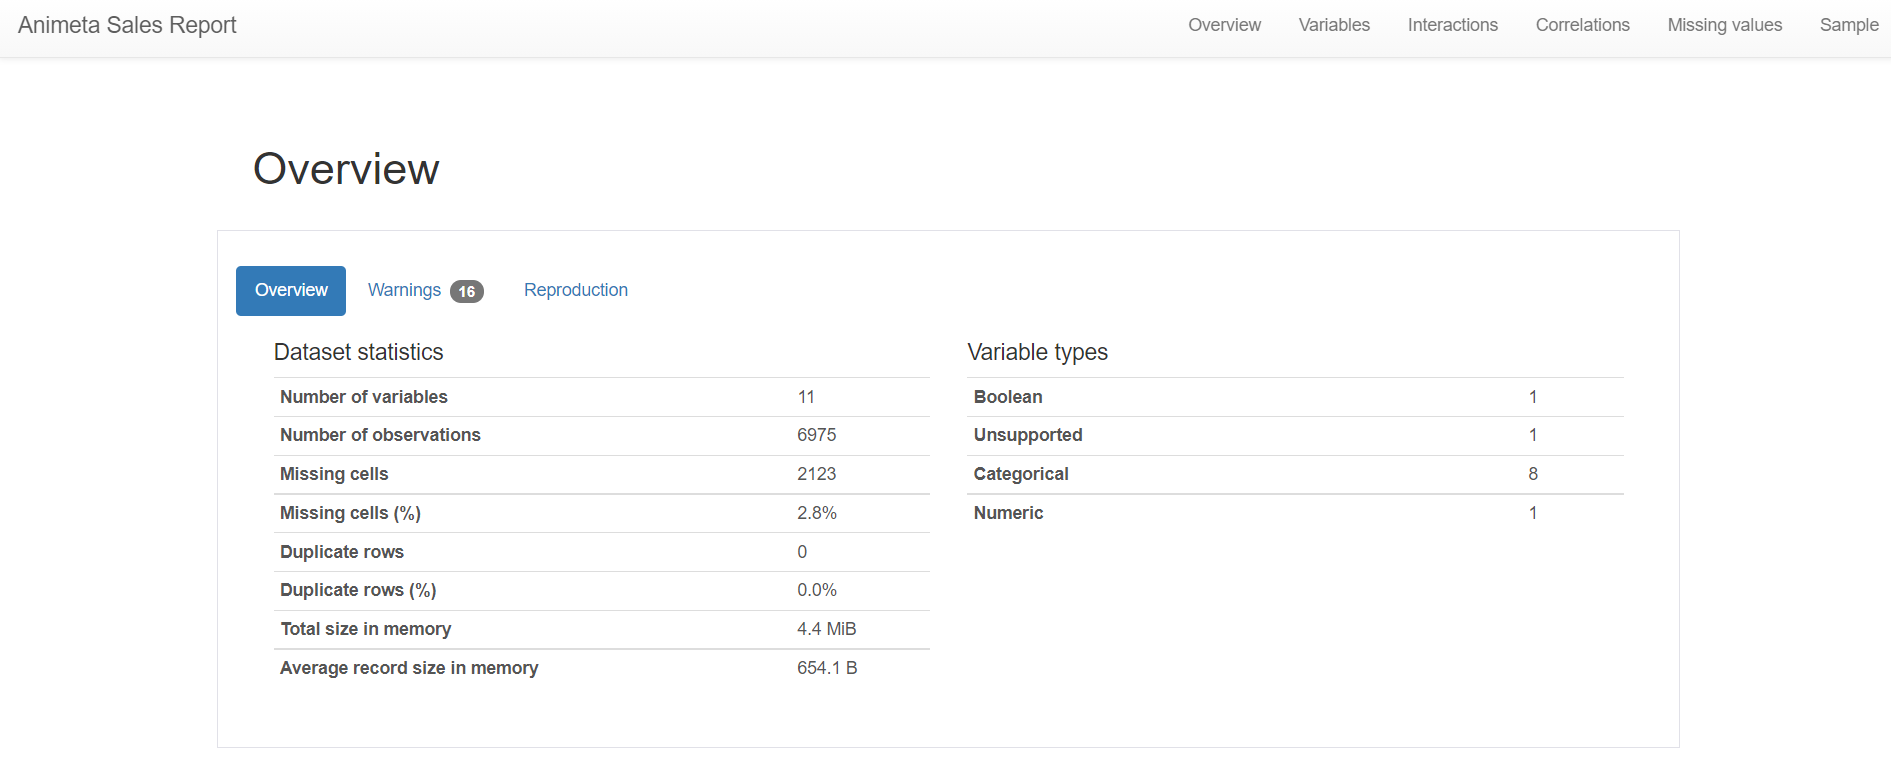

In [17]:
# pandas profiling reports can be generated for smaller collections
"""
event_report = ProfileReport(assets_df, title="events Report", explorative=True)
event_sales_report = ProfileReport(events_sales_df, title="event Sales Report", explorative=True)
event_report.to_file("event_report.html")
event_sales_report.to_file("event_sales_report.html")
"""

'\nevent_report = ProfileReport(assets_df, title="events Report", explorative=True)\nevent_sales_report = ProfileReport(events_sales_df, title="event Sales Report", explorative=True)\nevent_report.to_file("event_report.html")\nevent_sales_report.to_file("event_sales_report.html")\n'

### Analyzing events' Sellers and Buyers

Understanding how many people are buying and selling a collection can give information on what kind of project it is. 
If there are many transactions all between not that many users, it could be a red flag and a reason to do more research into the project.

In [18]:
print("There are %d unique asset sellers." % len(events_sales_df['seller_address'].unique()))
print("There are %d unique asset buyers." % len(events_sales_df['buyer_address'].unique()))

There are 3636 unique asset sellers.
There are 4868 unique asset buyers.


#### Getting Top 10 events Buyers

The OpenSea API is convenient in that it allows developers to programatically access the username of buyers and sellers giving more context into WHO is doing the buying and selling. 

In [19]:
buyers = []
for buyer_address in events_sales_df['buyer_address'].value_counts().index[:10]:
    buyer_data = {}
    buyer_data['buyer_address'] = buyer_address
    buyer_data['buyer_username'] = events_sales_df[events_sales_df['buyer_address'] == buyer_address]['buyer_username'].iloc[0]
    buyer_data['number_buys'] = len(events_sales_df[events_sales_df['buyer_address'] == buyer_address])
    buyer_data['min_price'] = events_sales_df[events_sales_df['buyer_address'] == buyer_address]['total_price'].min()
    buyer_data['max_price'] = events_sales_df[events_sales_df['buyer_address'] == buyer_address]['total_price'].max()
    buyer_data['mean_price'] = events_sales_df[events_sales_df['buyer_address'] == buyer_address]['total_price'].mean()
    buyers.append(buyer_data)
    
pd.DataFrame(buyers)

,buyer_address,buyer_username,number_buys,min_price,max_price,mean_price
0,0xa422bfff5daba6eeefaff84debf609edf0868c5f,h49_vault,183,0.1300,1.00,0.661579
1,0xc6a7463a7ee700d035aff7bfd1ee198d680a4164,BobTheNailer,113,0.1190,2.75,0.393596
2,0x5d9049fccf5ae287ca2472713bb7fc6325dc7876,0X0923,110,0.2800,3.50,0.604512
3,0x7c8f4a31bfa6a2bc70e538dec4636da3c531abe8,NanoChip,98,0.1188,10.00,0.644079
4,0x0b2c327046b9f66e11752d1220bed0712b0d0188,likaboss,94,0.1590,0.80,0.299877
5,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,MachiBigBrother,88,0.3190,7.50,1.827024
6,0x5cfa2c097d5f5ca13ff0ff3a2693cda8c026efd0,Animetas4Life,82,0.2000,0.25,0.224453
7,0x65217c49f9f1c4b5d468bcbf2942310cff530df1,C9F8EJJ8ED,76,0.1000,0.50,0.198117
8,0x27cfb1b71a3dcd6b7f19c273b70154a516b17c4f,Sir_PantsALot,75,0.1000,9.00,0.803684
9,0x3ecc3c48310300eb71959ace8bd670960f0a8815,JiriK,62,0.2450,0.37,0.286806


#### Getting Top 10 events Sellers

In [20]:
sellers = []
for seller_address in events_sales_df['seller_address'].value_counts().index[:10]:
    seller_data = {}
    seller_data['seller_address'] = seller_address
    seller_data['seller_username'] = events_sales_df[events_sales_df['seller_address'] == seller_address]['seller_username'].iloc[0]
    seller_data['number_sales'] = len(events_sales_df[events_sales_df['seller_address'] == seller_address])
    seller_data['min_price'] = events_sales_df[events_sales_df['seller_address'] == seller_address]['total_price'].min()
    seller_data['max_price'] = events_sales_df[events_sales_df['seller_address'] == seller_address]['total_price'].max()
    seller_data['mean_price'] = events_sales_df[events_sales_df['seller_address'] == seller_address]['total_price'].mean()
    sellers.append(seller_data)
    
pd.DataFrame(sellers)

,seller_address,seller_username,number_sales,min_price,max_price,mean_price
0,0xbff79922fcbf93f9c30abb22322b271460c6bebb,avarice,172,0.1800,1.850,0.299395
1,0x7c8f4a31bfa6a2bc70e538dec4636da3c531abe8,NanoChip,148,0.1500,1.400,0.404412
2,0x65217c49f9f1c4b5d468bcbf2942310cff530df1,C9F8EJJ8ED,101,0.2300,4.500,0.739970
3,0x88923378021bea85f9b09ce571a309e12c7d2262,8892,101,0.1200,2.750,0.361703
4,0xf889bdc0686274a419415298122b1086f0ce4a1d,0x125235,88,0.1500,0.180,0.163154
5,0x5cfa2c097d5f5ca13ff0ff3a2693cda8c026efd0,Animetas4Life,82,0.2900,3.000,0.584512
6,0x86494a5eb108ca2068a5bd55f617d430bc6d5eba,0xNew1,80,0.1189,3.490,0.256561
7,0x6708193ae7bbc4fc46b7e6a00af87a2b78fdb19f,Flash_NFT,78,0.1800,1.999,0.320304
8,0x0b2c327046b9f66e11752d1220bed0712b0d0188,likaboss,76,0.0000,9.990,0.767936
9,0xf8a3db410668e79e1179fd54dfec9e78269694c0,None,69,0.1700,1.000,0.395754


#### Intersection of Top 10 Buyers and Top 10 sellers

In [21]:
top_10_buyers = events_sales_df['buyer_username'].value_counts().index[:10]
top_10_sellers = events_sales_df['seller_username'].value_counts().index[:10]
print(list(set(top_10_buyers) & set(top_10_sellers)))

['NanoChip', 'likaboss', 'Animetas4Life', 'C9F8EJJ8ED']


#### Getting Number of Sales between same Buyers and Sellers 

In [22]:
(events_sales_df['seller_address'] + events_sales_df['buyer_address']).value_counts().value_counts()

1    13465
2      342
3       36
4       19
5        7
6        4
9        1
7        1
dtype: int64

### Getting Top 10 asset Owners

We also want to see who is holding the most of any asset. This information is actually also available on the Etherscan website for any collection by looking at the token holders.

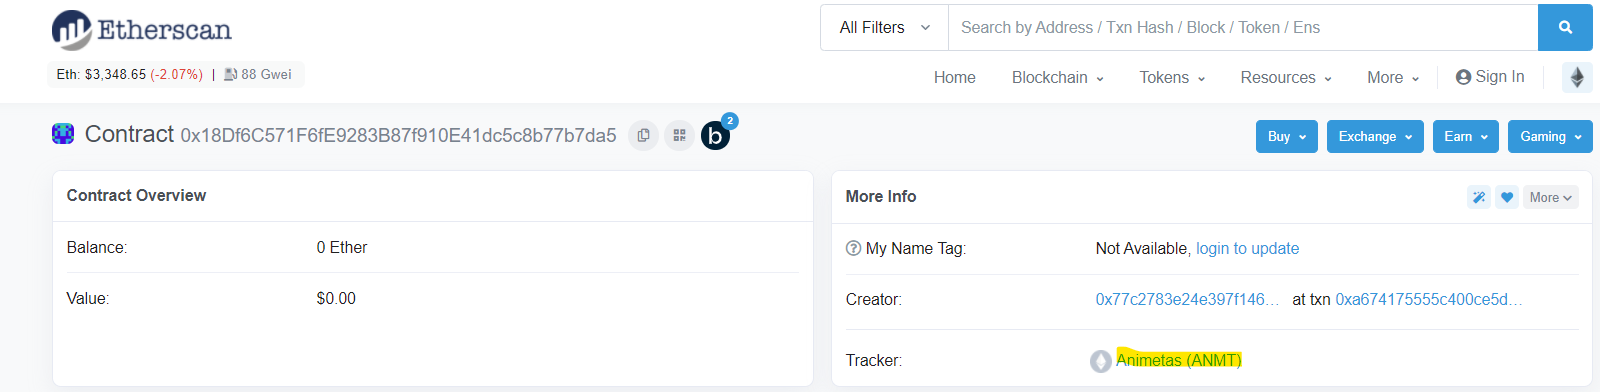

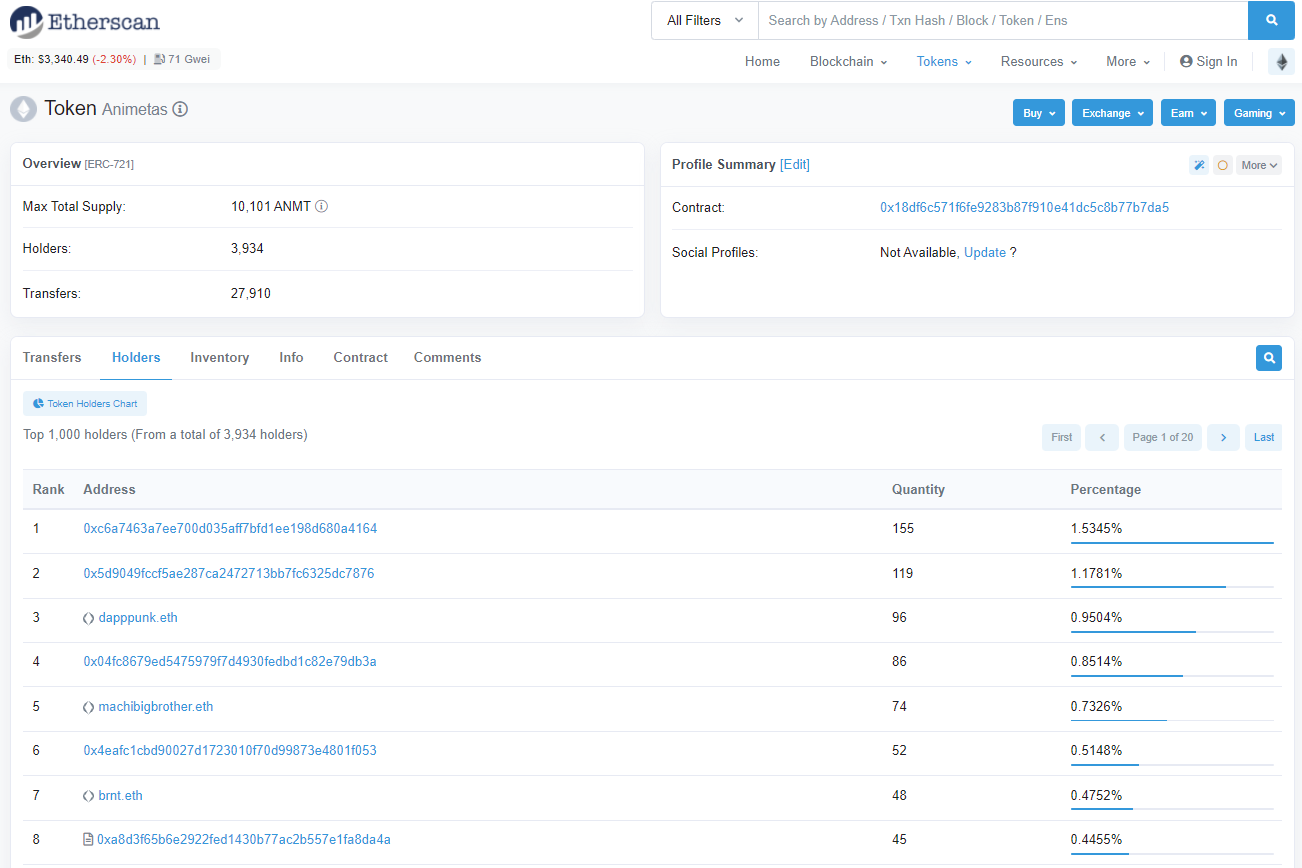

In [23]:
owners = []
for owner_address in assets_df['owner_address'].value_counts().index[:10]:
    owner_data = {}
    owner_data['owner_address'] = owner_address
    owner_data['owner_username'] = assets_df[assets_df['owner_address'] == owner_address]['owner_username'].iloc[0]
    owner_data['number_assets'] = len(assets_df[assets_df['owner_address'] == owner_address])
    owners.append(owner_data)

pd.DataFrame(owners)

,owner_address,owner_username,number_assets
0,0xc6a7463a7ee700d035aff7bfd1ee198d680a4164,BobTheNailer,155
1,0x5d9049fccf5ae287ca2472713bb7fc6325dc7876,0X0923,119
2,0x8ee376de530fb9a734df676e7e4342b48355f483,DappPunk,96
3,0x04fc8679ed5475979f7d4930fedbd1c82e79db3a,None,86
4,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,MachiBigBrother,74
5,0xa8d3f65b6e2922fed1430b77ac2b557e1fa8da4a,None,64
6,0x4d93c788b6e9771f1ee2f30242cd3892b631d8ed,brent9two,48
7,0x4eafc1cbd90027d1723010f70d99873e4801f053,V1000,45
8,0x1d3643399e5534dd49f2b04f2f0615153bd209fd,hive,43
9,0xb07c70eccb3373e9108a436cc1028d2ec6312ebf,NFT11988,42


In [24]:
#### Getting total number of event Creators and Owners.
print("There are %d unique asset creators." % len(assets_df['creator_address'].unique()))
print("There are %d unique asset owners." % len(assets_df['owner_address'].unique()))

There are 2 unique asset creators.
There are 3918 unique asset owners.


# Macro Visualization<a class="anchor" id="visual"></a>


Now that we have an understanding about the assets, no in order to get an understanding of the market dynamics to date, we can visualize our events.

1. Total number of sales per Day (count & log count)
2. Value of the day's trades in ETH and USD equivalent
3. The average and median price of all sales 
4. The floor price, or lowest price of an asset sold for during that period of time
5. The highest price an asset sold for by day
6. Total number of listings per day

These are interesting metrics that only begin to scratch the surface of a collection but can be the base of an expansive inquiry. There are many different views to work with and combining them into composite charts are often more informational. If you want to create production ready HTML visuals, I recommend exploring the Plotly package. 

In the next part of this series, we will look at a different way of exploring a collection but this time digging one layer deeper and comparing the NFT’s by their often-unique traits.

### events Sales Timelines

#### Total Number of Sales per Day

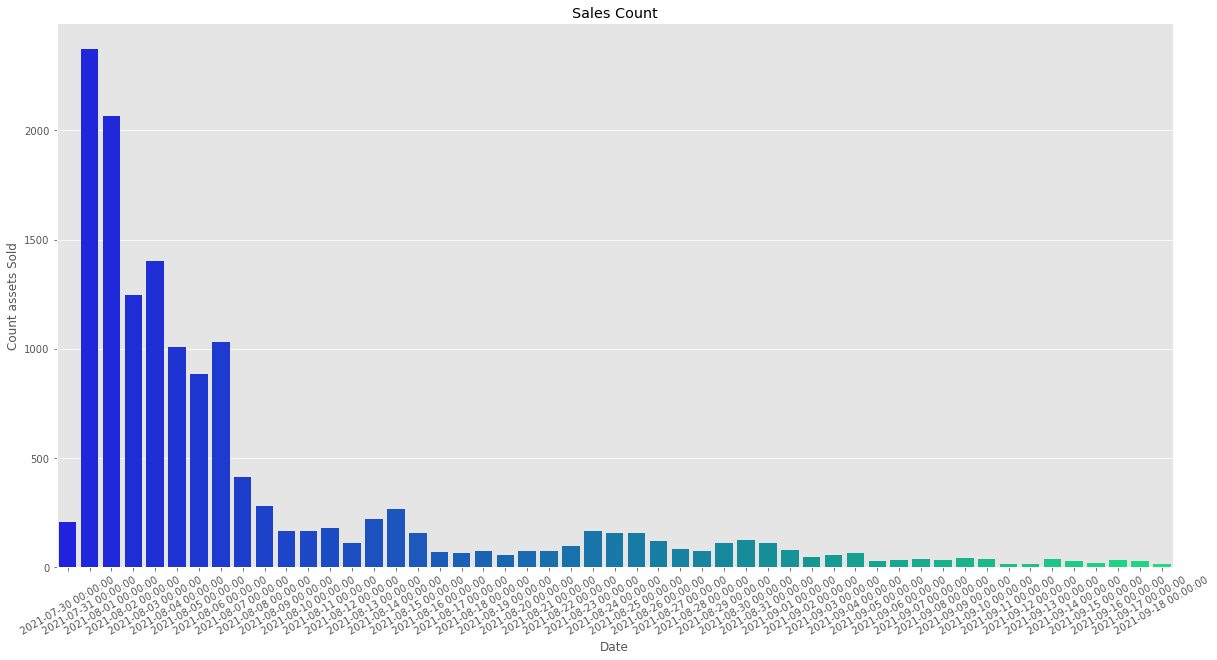

In [25]:
data = events_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').count()['total_price']
data = pd.DataFrame(data)
data.columns = ['Count assets Sold']
#ax = data.plot.bar(figsize=(18, 5))

plt.figure(figsize=(20,10))
ax = sns.barplot(x=data.index, y=data['Count assets Sold'], palette="winter")
plt.xlabel("Date")
plt.title("Sales Count")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);
#ax.xaxis.set_major_locator(plt.MaxNLocator(100));

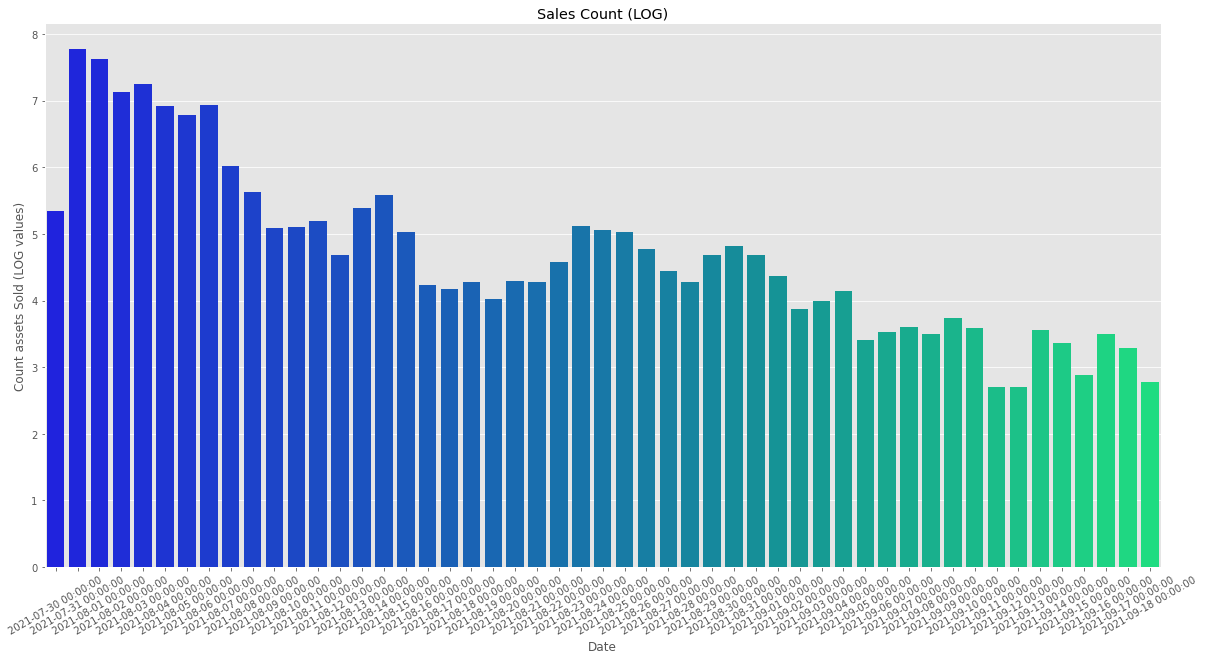

In [26]:
data = events_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').count()['total_price']
data = pd.DataFrame(data)
data.columns = ['Count assets Sold']
data['Count assets Sold'] = np.log(data['Count assets Sold'])
#ax = data.plot.bar(figsize=(18, 5))

plt.figure(figsize=(20,10))
ax = sns.barplot(x=data.index, y=data['Count assets Sold'], palette="winter")
plt.xlabel("Date")
plt.ylabel("Count assets Sold (LOG values)")
plt.title("Sales Count (LOG)")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);
#ax.xaxis.set_major_locator(plt.MaxNLocator(100));

#### Total Sales per Day in ETH

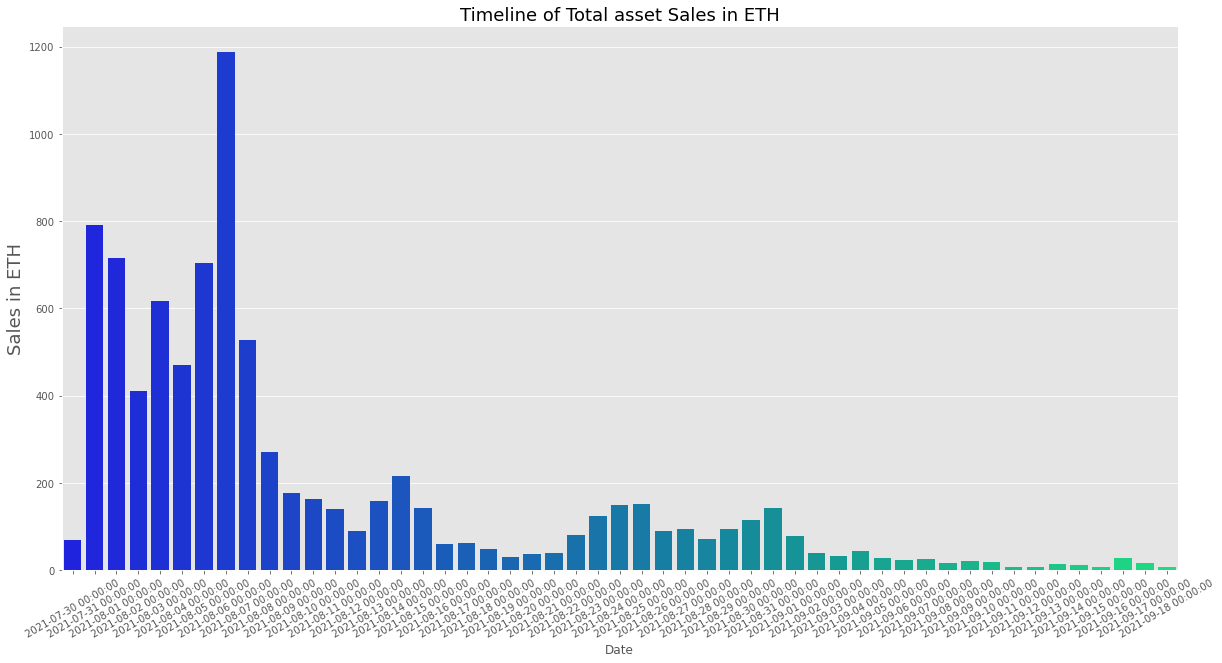

In [27]:
data = events_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').sum()['total_price']
data = pd.DataFrame(data)
data.columns = ['total_price']

plt.figure(figsize=(20,10))
ax=sns.barplot(x=data.index, y=data['total_price'], palette="winter")
plt.xlabel("Date")
plt.title("Sales Count")

ax.set_title("Timeline of Total asset Sales in ETH", fontsize=18)
ax.set_ylabel("Sales in ETH", fontsize=18);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);


#### Total Sales per day in USD

<ipython-input-28-9e70797a0a1c>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s="{:.2f}".format(j/10.**6), xy=(i, j), rotation=45)


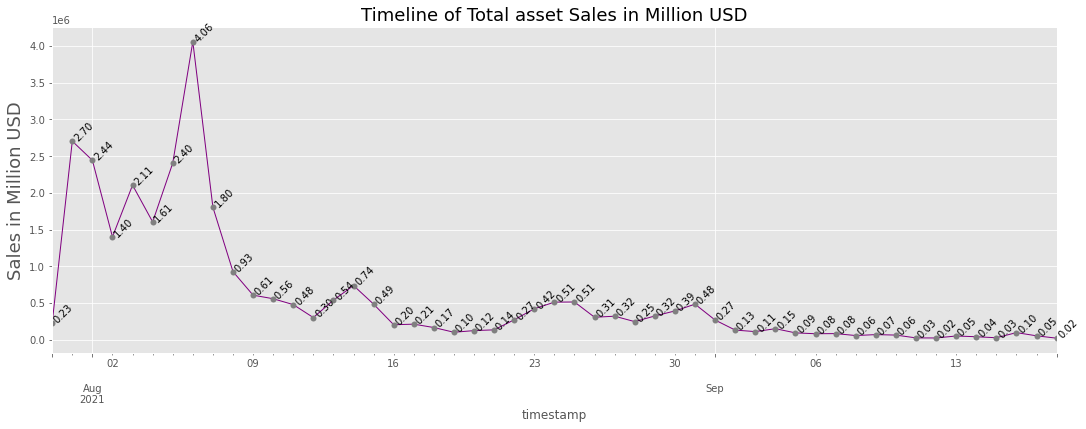

In [28]:
data = events_sales_df[['timestamp', 'total_price_usd']].resample('D', on='timestamp').sum()['total_price_usd']
ax = data.plot(figsize=(18,6), color="purple", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Total asset Sales in Million USD", fontsize=18)
ax.set_ylabel("Sales in Million USD", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.2f}".format(j/10.**6), xy=(i, j), rotation=45)

### Asset Prices Timelines 

#### Average asset Price per Day in ETH 

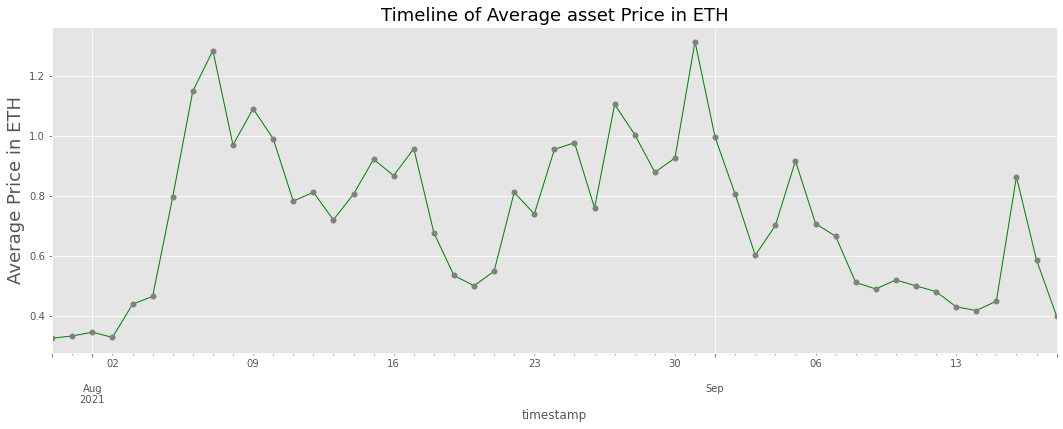

In [29]:
data = events_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').mean()['total_price']
ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Average asset Price in ETH", fontsize=18)
ax.set_ylabel("Average Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

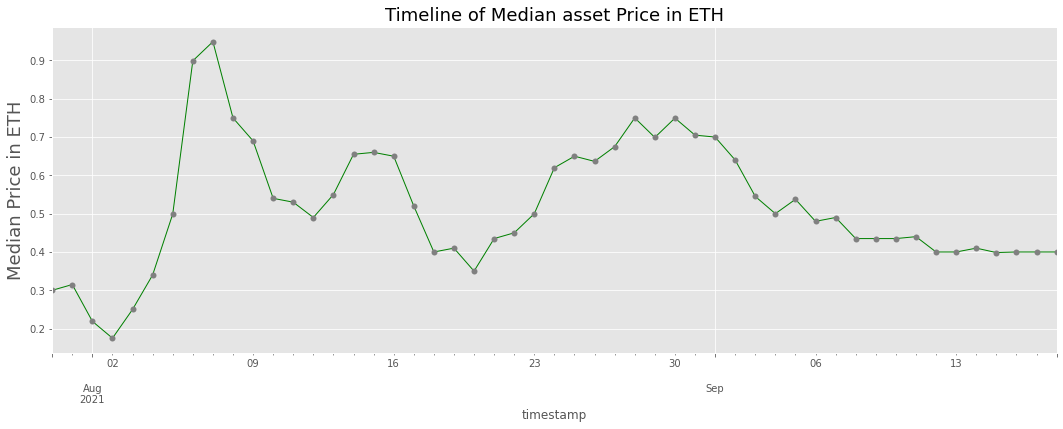

In [30]:
data = events_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').median()['total_price']
ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Median asset Price in ETH", fontsize=18)
ax.set_ylabel("Median Price in ETH", fontsize=18);
#ax.annotate(s='sdsdsds', xy=(1, 1))

dates = list(data.index)
values = list(data.values)

#### Floor asset Price per Day in ETH

<ipython-input-37-fb01d7c24f1e>:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s="{:.5f}".format(v), xy=(d, v), rotation=45)


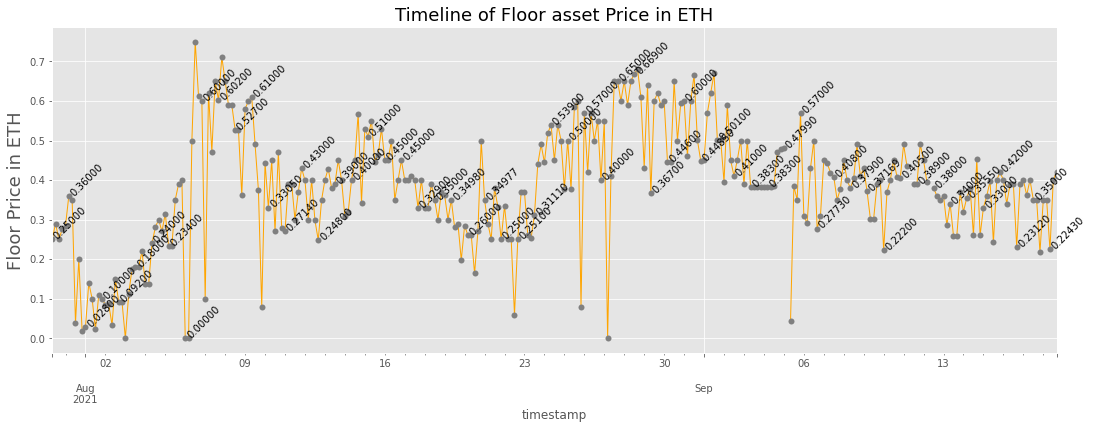

In [37]:
data = events_sales_df[['timestamp', 'total_price']].resample('240min', on='timestamp').min()['total_price']
ax = data.plot(figsize=(18,6), color="orange", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Floor asset Price in ETH", fontsize=18)
ax.set_ylabel("Floor Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for idx, (d, v) in enumerate(zip(dates, values)):
    if idx%5 == 0:
        ax.annotate(s="{:.5f}".format(v), xy=(d, v), rotation=45)

#### Max event Price per Day in ETH

<ipython-input-32-cb48f2fde8ca>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s="{:.0f}".format(j), xy=(i, j+1), rotation=45)


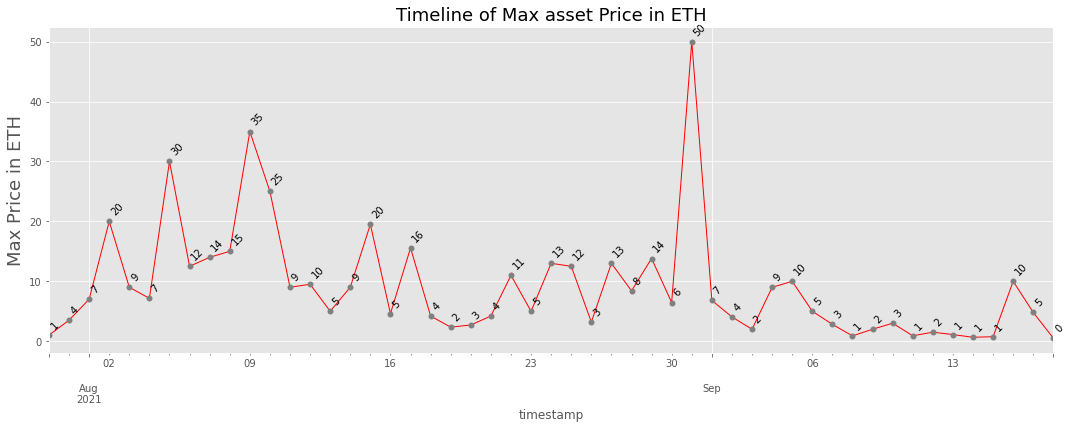

In [32]:
data = events_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').max()['total_price']
ax = data.plot(figsize=(18,6), color="red", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Max asset Price in ETH", fontsize=18)
ax.set_ylabel("Max Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.0f}".format(j), xy=(i, j+1), rotation=45)

### Assets Listings Timelines

#### Total Number of listings per Day

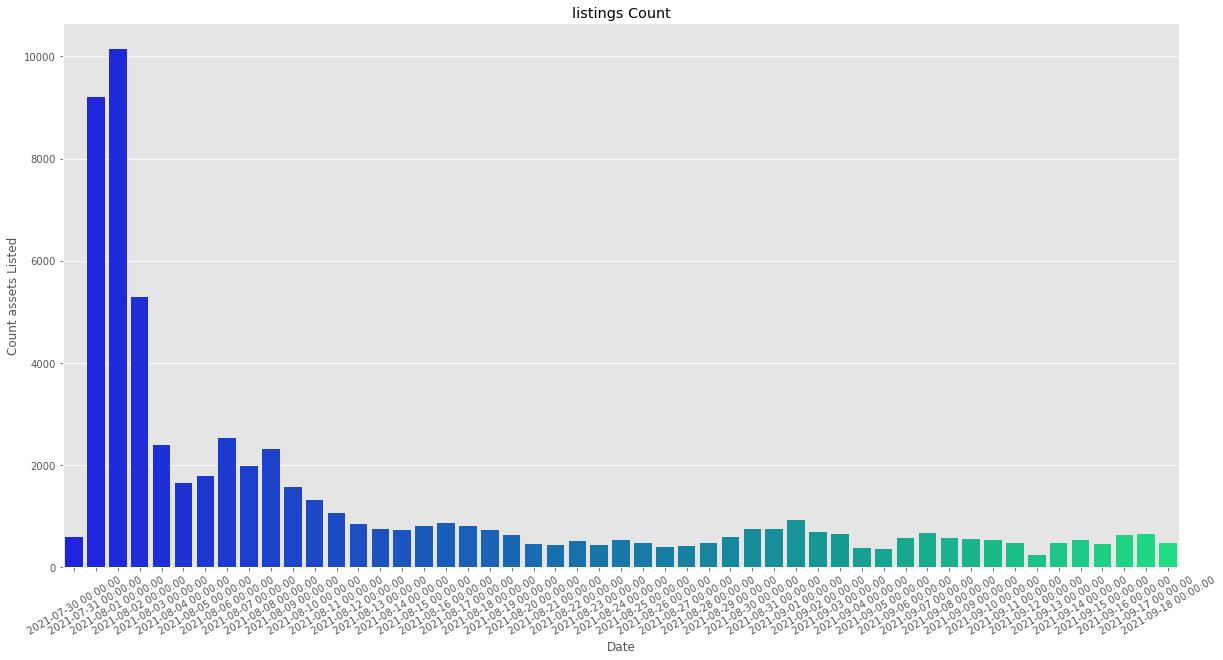

In [33]:
data = events_listings_df[['created_date', 'starting_price']].resample('D', on='created_date').count()['starting_price']
data = pd.DataFrame(data)
data.columns = ['Count assets Listed']
#ax = data.plot.bar(figsize=(18, 5))

plt.figure(figsize=(20,10))
ax = sns.barplot(x=data.index, y=data['Count assets Listed'], palette="winter")
plt.xlabel("Date")
plt.title("listings Count")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

In [34]:
data

,Count assets Listed
created_date,
2021-07-30,585
2021-07-31,9198
2021-08-01,10139
2021-08-02,5282
2021-08-03,2395
2021-08-04,1640
2021-08-05,1774
2021-08-06,2530
2021-08-07,1981



# References

[0] [Data mining Meebits](http://adilmoujahid.com/posts/2021/06/data-mining-meebits-nfts-python-opensea/)

[1] [Fungibility - Wikipedia](https://en.wikipedia.org/wiki/Fungibility)

[2] [A Practical Introduction to NFTs using Solidity and Legos](http://adilmoujahid.com/posts/2021/05/intro-nfts-solidity/)

[3] [Counterparty - Wikipedia](https://bit.ly/3h6IfMU)

[4] [Counterparty - Bitcoinwiki](https://bit.ly/2T79teI)

[5] [Rare Pepe Gets Blockchained, Made Into Tradable Counterparty Tokens](https://news.bitcoin.com/rare-pepe-assets-get-blockchained/)